In [1]:
import numpy as np
import matplotlib
import random
import time
import psutil
import matplotlib.pyplot as plt
import timeit

In [2]:
!pip install memory_profiler

In [3]:
from memory_profiler import memory_usage

Random Sequence Generator

In [4]:
def generate_random_sequence(length):
    nucleotides = ['A', 'T', 'C', 'G']
    random_sequence = [random.choice(nucleotides) for i in range(length)]
    return ''.join(random_sequence)

# Testing randomly generated sequences
# short
a = generate_random_sequence(5)
b = generate_random_sequence(10)
c = generate_random_sequence(20)
d = generate_random_sequence(100)
e = generate_random_sequence(1000)

#long
f = generate_random_sequence(2000)
g = generate_random_sequence(5000)
h = generate_random_sequence(10000)

print("Short Sequences (5-1000 BP): ")
print(a)
print(b)
print(c)
print(d)
print(e)

print("Long Sequences (2000-10000 BP): ")
print(f)
print(g)
print(h)

Short Sequences (5-1000 BP): 
CATTC
TCGGTCCACG
AGCACGCCAGATCAAGATTA
CCATCGGGAGGCGTGTCGCTTACGACTGACCTTTTAGTAATTTTCGACTTTCTCGTTGTACTGGGTGGTTTGGGCATCACCGTATTGACTTCGATGAATA
GTATACTCAAGAAGGTCACTGCCTAAATGCCATCTCTGGGGTGGGGTAGCTTCAACGGAGCTCGTGACACGGATCTCGGACCCGATAGATCGTAGCATTCATATTAAGACTCGCGCGAGATACTGCGTCGCAGTCTGGCCCTCGAGTGTGCGCTCCAGAGCCGATAGCTTCGAAGATATTCTAGGAAATAGCGTATTCGGGTCAATCTTTCCAATTCAAGGTTGCGTGCTCTCCGATAAGCAAGCAAATCTCTCTCTAAGACTCCTAGCAGTGCTGACGCAATTGCGATCCAATGGACACTATGAATATTCCAACACCCAACCTGCCACATGAGAGTAACCGATACCGCCGTTCGCTCGGCCCTTAAGTAAGCGTCTGAGGGAGTAGCTTGGTGCACGAGTCTCTGTCGACGTTCAAGGTTCGCCTTGCACATTGGGAGGTTCCGACAGTTTTGCGCGAATCACGATAAGGGAAAAGTGGGGCTGCTGACTCCTGTATCGGGCTTTTACTCTTTAAGTCGTGTACCAACGCAGACGCAGTATGTGTCACAGTCCGATGGAGCTATCTCTATATTTTTAATTACGTGCTCGAGTCCGTCATTGCTGATTCTCCTTGGGTAAGTCCTATAGAACCACTGGGCGTGTGAAATGTTTTATTGGGATCCAAAGACAGGCGCAAGCGTGGACGCCTAGATGTGCGTATGGATTCGCTGTGTCTGTTCGCCTATTGGCTGGTGGCAACAATCATCGCGCAGTCGGTGTGATGATCCACGAGGTTTGACACGTCCGCTTCATCCAGGCTCACGATTTGCAAAGCAAGCTATCAGCCAAT

### Needleman-Wunsch (Baseline)

In [5]:
MATCH = 1
MISMATCH = -1
GAP = -1

def match_score(char1, char2):
    if char1 == char2:
        return MATCH
    elif char1 == '-' or char2 == '-':
        return GAP
    else:
        return MISMATCH

In [6]:
# We define a function just to print the aligned sequences and their scores in an easily understandable way
def print_sequence_alignment(seq1, seq2):
    aligned_symbol = ''
    score = 0

    for aa1, aa2 in zip(seq1, seq2):
        if aa1 == aa2:
            aligned_symbol += aa1
            score += match_score(aa1, aa2)
        elif aa1 != aa2 and aa1 != '-' and aa2 != '-':
            aligned_symbol += ' '
            score += match_score(aa1, aa2)
        elif aa1 == '-' or aa2 == '-':
            aligned_symbol += ' '
            score += GAP

    print(f'Score = {score}')
    print(seq1)
    print(seq2)

In [7]:
UP = (-1,0)
LEFT = (0, -1)
TOPLEFT = (-1, -1)
ORIGIN = (0, 0)

def traceback_global(v, w, pointers):
    i,j = len(v), len(w)
    new_v = []
    new_w = []
    while True:
        di, dj = pointers[i][j]
        if (di,dj) == LEFT:
            new_v.append('-')
            new_w.append(w[j-1])
        elif (di,dj) == UP:
            new_v.append(v[i-1])
            new_w.append('-')
        elif (di,dj) == TOPLEFT:
            new_v.append(v[i-1])
            new_w.append(w[j-1])
        i, j = i + di, j + dj

        if (i <= 0 and j <= 0):
            break

    # we update the HW1 code for our need with the project
    return ''.join(new_v[::-1]), ''.join(new_w[::-1])


def global_align_needleman_wunsch(v, w, delta):
    """
    Returns the score of the maximum scoring alignment of the strings v and w, as well as the actual alignment as
    computed by traceback_global.

    :param: v
    :param: w
    :param: delta
    """
    M = [[0 for j in range(len(w)+1)] for i in range(len(v)+1)]
    pointers = [[ORIGIN for j in range(len(w)+1)] for i in range(len(v)+1)]

    for i in range(1, len(v) + 1):
        M[i][0] = M[i - 1][0] + delta[v[i - 1]]['-']
        pointers[i][0] = UP
    for j in range(1, len(w) + 1):
        M[0][j] = M[0][j - 1] + delta['-'][w[j - 1]]
        pointers[0][j] = LEFT

    # Fill in the dynamic programming table M and the backpointer table pointers
    for i in range(1, len(v) + 1):
        for j in range(1, len(w) + 1):

            deletion = M[i - 1][j] + delta[v[i - 1]]['-']
            insertion = M[i][j - 1] + delta['-'][w[j - 1]]
            matching = M[i - 1][j - 1] + delta[v[i - 1]][w[j - 1]]

            M[i][j] = max(matching, deletion, insertion)

            if M[i][j] == matching:
                pointers[i][j] = TOPLEFT
            elif M[i][j] == deletion:
                pointers[i][j] = UP
            else:
                pointers[i][j] = LEFT

    score = M[len(v)][len(w)]
    alignment1, alignment2 = traceback_global(v, w, pointers)

    return alignment1, alignment2, score


In [8]:
keys = ['A', 'C', 'T', 'G', '-']
delta = {}
for i in range(len(keys)):
    delta[keys[i]] = {k : v for (k,v) in zip(keys, [1 if keys[i] == keys[j]  else -1 for j in range(len(keys))])}

alignment1, alignment2, score = global_align_needleman_wunsch("TAGATA", "GTAGGCTTAAGGTTA", delta)
print_sequence_alignment(alignment1, alignment2)

Score = -3
-TA-G----A---TA
GTAGGCTTAAGGTTA


In [9]:
seq1 = "AGTACGCA"
seq2 = "TATAGC"
a1, a2, score = global_align_needleman_wunsch(seq1, seq2, delta)
print_sequence_alignment(a1, a2)

Score = 1
-AGTACGCA
TA-TA-GC-


# Hirschberg Algorithm

In [10]:
def get_prefix_suffix(seq1, seq2, is_prefix):
    m, n = len(seq1), len(seq2)
    score_table = np.zeros((m + 1, n + 1))

    # Initialize the first row for gaps
    score_table[0, :] = GAP * np.arange(n + 1)

    for i in range(1, m + 1):
        # Initialize the first column for gaps
        score_table[i, 0] = GAP + score_table[i - 1, 0]

        for j in range(1, n + 1):
            deletion = GAP + score_table[i - 1, j]
            insertion = GAP + score_table[i, j - 1]
            matching = score_table[i - 1, j - 1] + match_score(seq1[i - 1], seq2[j - 1]) if is_prefix else score_table[i - 1, j - 1] + match_score(seq1[m - i], seq2[n - j])
            score_table[i, j] = max(deletion, insertion, matching)

    return score_table[m, :]

In [11]:
def hirschberg(seq1, seq2):
    alignment_score = 0
    alignment_text = ""
    m = len(seq1)
    n = len(seq2)

    # base case
    if n < 2 or m < 2:
        # In this case, we just use the N-W algorithm.
        return global_align_needleman_wunsch(seq1, seq2, delta)

    # Make partitions - Calculate midpoint
    midpoint_value = m // 2 # // is integer diviison
    prefix = get_prefix_suffix(seq1[:midpoint_value], seq2, is_prefix=True)
    suffix = get_prefix_suffix(seq1[midpoint_value:], seq2, is_prefix=False)

    division = [prefix[j] + suffix[n - j] for j in range(n + 1)]

    # recursive call hirschberg
    # Divide and conquer
    left_alignment = hirschberg(seq1[:midpoint_value], seq2[:division.index(max(division))])
    right_alignment = hirschberg(seq1[midpoint_value:], seq2[division.index(max(division)):])

    # Combine results
    final_alignment = [left + right for left, right in zip(left_alignment, right_alignment)]

    return final_alignment

In [12]:
seq1 = "AGTACGCA"
seq2 = "TATAGCA"
print(hirschberg(seq1, seq2))

['-AGTACGCA', 'TA-TA-GCA', 3]


# Time and Memory


In [13]:
def find_memory_and_time(target_function, *args):
    # Execute the target function to establish baseline memory usage
    baseline_memory = memory_usage(max_usage=True)

    # Record start time
    start_time = timeit.default_timer()

    # Configure memory profiler to monitor the target function
    memory_usage_data = memory_usage((target_function, args), interval=0.001, include_children=True)

    # Record end time - the timeit library is noted to have more accurate time keeping, so we are using it for our final project
    end_time = timeit.default_timer()

    # Find peak memory use increase
    peak_memory = max([memory - baseline_memory for memory in memory_usage_data])

    # Calculate total execution time in milliseconds
    execution_time = (end_time - start_time) * 1000

    return peak_memory, execution_time

In [14]:
# Run N-W and Hirschberg Algorithm for randomly generated input sequences of different sizes
input_sizes = [100, 200, 400, 600, 800, 1000, 1500, 2000, 2500, 3000, 3500, 4000]

alignments_nw = []
execution_times_nw = []
memory_usages_nw = []

alignments_hirschberg = []
execution_times_hirschberg = []
memory_usages_hirschberg = []

for size in input_sizes:
    seq1 = generate_random_sequence(size)
    seq2 = generate_random_sequence(size)

    mem_usage_nw, exec_time_nw = find_memory_and_time(global_align_needleman_wunsch, seq1, seq2, delta)
    execution_times_nw.append(exec_time_nw)
    memory_usages_nw.append(mem_usage_nw)

    mem_usage_hirschberg, exec_time_hirschberg = find_memory_and_time(hirschberg, seq1, seq2)
    execution_times_hirschberg.append(exec_time_hirschberg)
    memory_usages_hirschberg.append(mem_usage_hirschberg)


print("execution_times_nw", execution_times_nw)
print("execution_times_hirschberg", execution_times_hirschberg)

execution_times_nw [95.28167600001325, 79.8955649988784, 248.81711899797665, 1407.321406997653, 4034.2865540005732, 1599.2101250012638, 4972.7886079999735, 8142.87855099974, 11509.33582200014, 16585.30207399963, 22569.21289299862, 28952.83981600005]
execution_times_hirschberg [142.31020000079297, 305.2823449979769, 1000.0965239996731, 2636.194004997378, 8261.33727100023, 4880.440630000521, 9254.788244001247, 18248.610023001675, 28517.150140000012, 41634.21257299706, 54858.963136000966, 75793.98980800033]


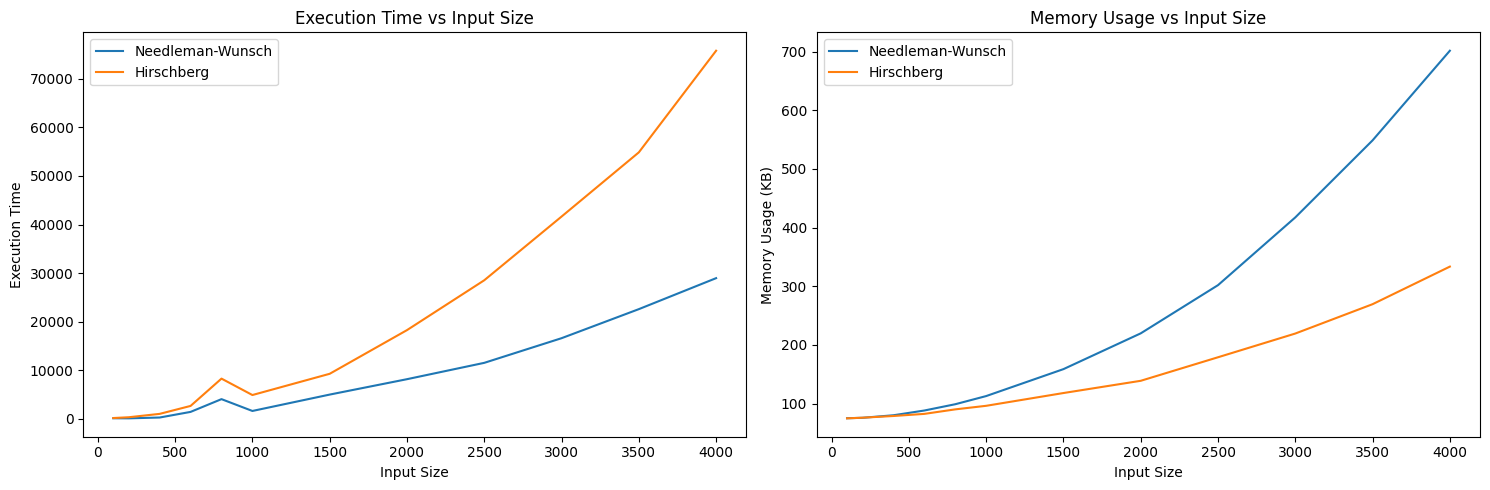

In [15]:
# Plotting for Execution Time
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(input_sizes, execution_times_nw, label='Needleman-Wunsch')
plt.plot(input_sizes, execution_times_hirschberg, label='Hirschberg')
plt.title('Execution Time vs Input Size')
plt.xlabel('Input Size')
plt.ylabel('Execution Time')
plt.legend()

# Plotting for Memory Usage
plt.subplot(1, 2, 2)
plt.plot(input_sizes, memory_usages_nw, label='Needleman-Wunsch')
plt.plot(input_sizes, memory_usages_hirschberg, label='Hirschberg')
plt.title('Memory Usage vs Input Size')
plt.xlabel('Input Size')
plt.ylabel('Memory Usage (KB)')
plt.legend()

plt.tight_layout()
plt.show()

# Test Cases

In [16]:
#test case 1
#short sequences

seq1 = generate_random_sequence(7)
seq2 = generate_random_sequence(7)

#needleman wunsch
aw1, aw2, score = global_align_needleman_wunsch(seq1, seq2, delta)
print("Needleman-Wunsch Implementation: ")
print_sequence_alignment(aw1, aw2)

#hirschberg
ah1, ah2, score = hirschberg(seq1, seq2)
print("Hirschberg Implementation: ")
print_sequence_alignment(ah1, ah2)

Needleman-Wunsch Implementation: 
Score = 0
ATTCGAG-
A-TGGGGT
Hirschberg Implementation: 
Score = 0
ATTCGAG-
A-TGGGGT


In [17]:
#test case 2
#short sequences

seq1 = generate_random_sequence(15)
seq2 = generate_random_sequence(15)


#needleman wunsch
aw1, aw2, score = global_align_needleman_wunsch(seq1, seq2, delta)
print("Needleman-Wunsch Implementation: ")
print_sequence_alignment(aw1, aw2)

#hirschberg
ah1, ah2, score = hirschberg(seq1, seq2)
print("Hirschberg Implementation: ")
print_sequence_alignment(ah1, ah2)

Needleman-Wunsch Implementation: 
Score = -1
CCTG-GCT-TAGCCCTA
GCAGCGCTCAAGAGC--
Hirschberg Implementation: 
Score = -1
CCTG-GCTTA-GCCCTA
GCAGCGCTCAAGAGC--


In [20]:
#test case 3
#long sequences

seq1 = generate_random_sequence(1200)
seq2 = generate_random_sequence(1200)


#needleman wunsch
aw1, aw2, score = global_align_needleman_wunsch(seq1, seq2, delta)
print("Needleman-Wunsch Implementation: ")
print_sequence_alignment(aw1, aw2)

#hirschberg
ah1, ah2, score = hirschberg(seq1, seq2)
print("Hirschberg Implementation: ")
print_sequence_alignment(ah1, ah2)

Needleman-Wunsch Implementation: 
Score = 114
-CAGATCAG-AACCCATTGCGATATACGGCGCGCGCTGGGATAGTGCGAGACCA-AAAAAACAAGCGCTCTAGCAGTGAGATAAAAGGTTACG-ATACTGCCTC-AT-CACCTCTG---GCCGGT--GTTGCTGATGC-GGGCTATTGCAATGATAACCTGACTGGCCTACAATAATTCGGGTGCACGGGTATCAGCCCGAAAGCAGCACTGGTACCTAAGCAGCACCGTGAGCGTAT-ACGAATTCCCCGATATAAT-CGAAAGCTTC-GGT-TCCGA-TGTTTAATTTCAGC-A-CTA--GCTTCTTTCAGACACCCAAATGAAGCGG----G-TGTGG-AC-GGCTGTAC--G--CGAGAAGGACTC---CT-ACTGCT-GATTAT--TG-AC--C-AGGCCTATGCACGAATC-TTC-TCGTAGACACTGAG-AC-A-ATACT-AGCTCAAGATGATAAGGGA---CA-CGT--G-T-A-T-TTACCGGC-----GATCATGCGCCGTAATCATCTGCGCAT-TCCTGT-TTTC-CATCG-CGAAT-T-TGC-AGAGTCTC-GCTCGGCGG-CAATCAG-AG-A-GGTC--CT--TGAC--CTTCGAGCACCTA-T-GAGGATAC-AA----AAGCGCAAGCAGATAACC-ATAG-TCTAAGAGAG-GAGTTTA-AAC-CC-AGTATGT-A-AA-C-ACCTGA--A-AATC-TC-A--GGGACGGTATGCTTAGT-ACCCGCGTATGAGT-AGCGTTGAT-CTTTG-GAGTGCTAA-CCCTTGAGAAGCCTTC-T--C-A-CCT-TAA---AT--GCGGCCATCGCATC-A--CTGG-CTCCAG-GTATGATCGGT-TCCATGTCATGTT-CGCCA-GGTACGGGCATTCTTTC--C-ATGAGAACCTGG-TCAGGGGAGAGTACGAT-GACGA-T-AG--TTGCTGTCA